# Setup

## Packages

In [1]:
# Mark that the figures have been updated - ideally run just after saving
touch("./.figsentinel");

In [2]:
using WaterData
using DataFrames

## Plotting

In [3]:
# load plot packages
using PyPlot
using PyCall
using Colors
@pyimport seaborn as sb
@pyimport matplotlib.colors as mpc
LogNorm = mpc.LogNorm

# set plot styling
sb.set_style("white")
sb.set_style("ticks")
fontsize = 10
aspectratio = 1.5
fudgefactor = 1.2  # adjust until figure text size matches body text size
onecolwidth = 3.3  # inches
twocolwidth = 6.9  # inches
figsize = [1, 1/aspectratio] * onecolwidth * fudgefactor
bigfigsize = [1, 1/aspectratio] * twocolwidth * fudgefactor
tallfigsize = [1, 1.2] * onecolwidth * fudgefactor
widefigsize = [1, 1/2] * twocolwidth * fudgefactor
rc("figure", figsize=figsize, autolayout=false)
rc("axes", labelsize=fontsize)
rc(("xtick", "ytick"), labelsize=(fontsize - 1), direction="in")
rc("legend", fontsize=(fontsize - 1), loc="best")
rc("font", family="serif")
rc("savefig", bbox="tight", pad_inches=0.01)

# save location for these plots
figdir = "autofigs";

# functions for modifying color palettes
resetpalette!() = sb.set_palette("colorblind")
palette() = sb.color_palette()
palette(n) = sb.color_palette()[n]
function orderpalette(f, order)
    sb.set_palette(palette(order))
    f()
    resetpalette!()
end
resetpalette!()

# functions for adjusting spines
despine(;touching=true) = sb.despine(offset=(touching ? 0 : 10));

## Utilities

In [4]:
"Apply a function to each item in a sequence"
foreach(f, itr) = (for x in itr; f(x); end; nothing;)

"Wraps a plotting function in steps that set up the figure and save it"
function makefig(plotfunc, name; big=false, tall=false, wide=false)
    if big && tall
        error("not implemented")
    elseif big
        rc("figure", figsize=bigfigsize)
    elseif wide
        rc("figure", figsize=widefigsize)
    elseif tall
        rc("figure", figsize=tallfigsize)   
    end
    suffix = (big || wide) ? "_big_fig" : "_fig"
    figure()
    plotfunc()
    transparent=(1,1,1,1)
    svgname = "$figdir/$name$suffix.svg"
    pdfname = "$figdir/$name$suffix.pdf"
    savefig(svgname, transparent=true)
    savefig(pdfname, transparent=true)
    rc("figure", figsize=figsize)
end

"Placeholder block for test images"
function placeholder()
    x = 0:0.1:10
    y = (4 + 3sin(x), 6 + 3cos(x))
    xlim(0, 10)
    ylim(0, 10)
    xlabel("x-axis label")
    ylabel("y-axis label")
    text(5, 5, "Placeholder", fontsize=32,
        horizontalalignment="center", verticalalignment="center")
    plot(x, y[1])
    plot(x, y[2])
    despine()
end

"Read in a mass-radius data table"
readmr(source) = readtable("figdata/massradius/$source.csv", allowcomments=true)

"Remove zero tick labels from an axis"
function removezeroticks!(ax)
    ax[:get_yticklabels]()[1][:set_visible](false)
    ax[:get_xticklabels]()[1][:set_visible](false)
end

"Label an entire grid of subplots (x-axis)"
fullxlabel(fig, label; tweaky=0) = fig[:text](0.5, 0.02 + tweaky, label, ha=:center, fontsize=fontsize)
"Label an entire grid of subplots (y-axis)"
fullylabel(fig, label; tweakx=0) = fig[:text](0.06 + tweakx, 0.5, label, va=:center, rotation=:vertical, fontsize=fontsize);

# Equation of state

## Setup

In [5]:
# pull in the EOS data
eosdata = WaterData.load_full_eos()
eosraw = eosdata["raw"]
eosgrid = eosdata["grid"]
phaseboundaries = WaterData.load_phase_boundaries()
evapboundary = phaseboundaries["iapws"]
otherboundaries = phaseboundaries["dunaeva"]

minP, maxP = extrema(eosgrid.P)
minT, maxT = extrema(eosgrid.T)

# map (P, T) pairs to colors according to the dataset they come from
getphase(P, T) = WaterData.extracteos(eosraw, P, T)
nregions = length(eosraw.eoses)
eos_strings = ["iapws", "sugimura", "french", "I", "III", 
    "V", "VI", "VII", "iapws", "X", "X", "iapws", "iapws",
    "iapws", "fallback"]

# EOS to colour mappings
eos2colorstring = Dict(
    "iapws"=>"MistyRose",
    "sugimura"=>"Crimson",
    "french"=>"Pink",
    "VI"=>"Plum",
    "VII"=>"Thistle",
    "X"=>"PeachPuff")
colorstrings = map(eos_strings) do eos
    if eos in keys(eos2colorstring)
        eos2colorstring[eos]
    else
        "white"  # default color
    end
end
colors = map(c -> parse(Colorant, c), colorstrings)
cdict = Dict()
for (eos, color) in zip(eosraw.eoses, colors)
    if eos ∉ keys(cdict)
        cdict[eos] = color
    end
end

# make an image with those colours
cgrid = Matrix{RGB}(256, 256)
density = Matrix(256, 256)

for (iT, T) in enumerate(eosgrid.T), (iP, P) in enumerate(eosgrid.P)
    phase = getphase(P, T)
    density[iT, iP] = eosgrid(P, T)
    color = cdict[phase]
    cgrid[iT, iP] = color
end

# turn it into an NxMx3 array so matplotlib can read them (as RGB)
pyplot_cgrid = Array{Float64}(256, 256, 3)
pyplot_cgrid[:, :, 1] = map(red, cgrid)
pyplot_cgrid[:, :, 2] = map(green, cgrid)
pyplot_cgrid[:, :, 3] = map(blue, cgrid)

"Plot a phase boundary"
plotphase(boundary) = plot(boundary.P, boundary.T, linewidth=1, color=:black);

## Water phases

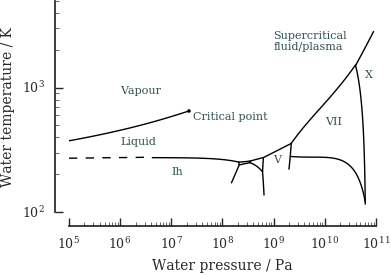

In [6]:
function plot_phase_boundaries()
    plotphase(evapboundary)
    foreach(plotphase, otherboundaries)
    plot([1e5, 4e6],[2.7e2, 2.75e2], "k--", linewidth=1)
    
    # put a dot at the critical point
    Pcrit = WaterData.Pc
    Tcrit = WaterData.Tc
    scatter(Pcrit, Tcrit, marker=".", s=20, c=:black)
end

makefig("water_phases") do
    plot_phase_boundaries()
    Pcrit = WaterData.Pc
    Tcrit = WaterData.Tc
    
    # annotate the regions and critical point
    anns = Dict(
        :fontsize=>fontsize-2,
        :color=>"darkslategray")
    annotate("Liquid", xy=(1e6, 3.5e2); anns...)
    annotate("Vapour", xy=(1e6, 9e2); anns...)
    annotate("Supercritical\nfluid/plasma", xy=(1e9, 2e3); anns...)
    annotate("Ih", xy=(1e7, 2e2); anns...)
    annotate("V", xy=(1e9, 2.5e2); anns...)
    annotate("VII", xy=(1e10, 5e2); anns...)
    annotate("X", xy=(6e10, 1.2e3); anns...)
    annotate("Critical point", xy=(Pcrit+5e6, Tcrit-1e2); anns...)
    
    # axes
    xlim(1e5, 1e11)
    ylim(100, 5000)
    xscale("log")
    yscale("log")
    despine(touching=false)
    xlabel("Water pressure / Pa")
    ylabel("Water temperature / K")
end

### Pressure-temperature profiles overlaid

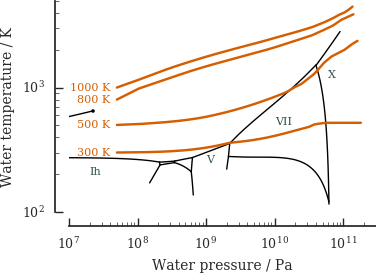

In [7]:
makefig("pressure_temperature_profiles") do
    plot_phase_boundaries()
    
    p300 = readtable("figdata/interior/300K.csv")
    p500 = readtable("figdata/interior/500K.csv")
    p800 = readtable("figdata/interior/800K.csv")
    
    function plot_profile(Tsurf)
        profile = readtable("figdata/interior/$(Tsurf)K.csv")
        plot(profile[:pressure], profile[:temperature], color=palette(3))
    end
    
    temps = [300, 500, 800, 1000]
    
    foreach(plot_profile, temps)
    
    # annotate the regions
    greyanns = Dict(
        :fontsize=>fontsize-2,
        :color=>"darkslategray")
    colanns = Dict(
        :fontsize=>fontsize-2,
        :color=>palette(3),
        :horizontalalignment=>:right,
        :verticalalignment=>:center)
    annotate("Ih", xy=(2e7, 2e2); greyanns...)
    annotate("V", xy=(1e9, 2.5e2); greyanns...)
    annotate("VII", xy=(1e10, 5e2); greyanns...)
    annotate("X", xy=(6e10, 1.2e3); greyanns...)
    foreach(temps) do T
        annotate("$T K", xy=(4e7, T); colanns...)
    end
        
    # axes
    xlim(1e7, 3e11)
    ylim(100, 5000)
    xscale("log")
    yscale("log")
    despine(touching=false)
    xlabel("Water pressure / Pa")
    ylabel("Water temperature / K")
end

## Our EOS sources

PyPlot.Figure(PyObject <matplotlib.figure.Figure object at 0x7f355a43cc18>)

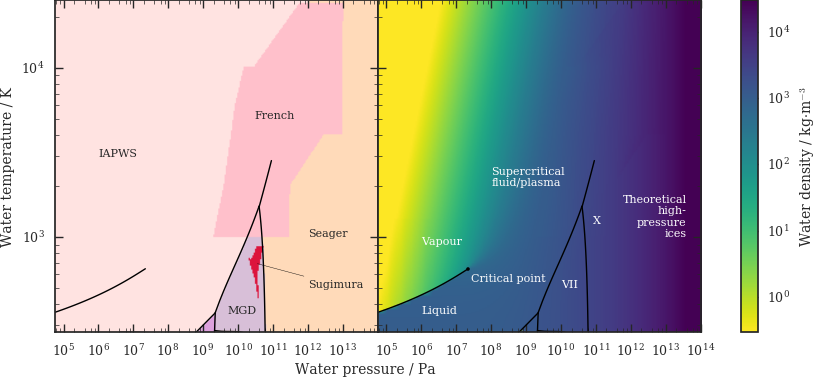

In [8]:
makefig("eos_phases"; wide=true) do
    fig, axes = subplots(1, 2, sharex=true, sharey=true)
    subplots_adjust(wspace=0, hspace=0, right=1.1)
    
    blackanns = Dict(
        :fontsize=>fontsize-2)
    whiteanns = Dict(
        :fontsize=>fontsize-2, 
        :color=>:white)
    Pcrit = WaterData.Pc
    Tcrit = WaterData.Tc
    
    # first plot: data regions
    sca(axes[1])
    
    # phase boundaries
    plotphase(evapboundary)
    foreach(plotphase, otherboundaries)

    # put in the key data regions
    imshow(pyplot_cgrid, aspect=:auto, origin=:lower,
        extent=(minP, maxP, minT, maxT)) 
    annotate("IAPWS", xy=(1e6, 3e3); blackanns...)
    annotate("French", xy=(3e10, 5e3); blackanns...)
    annotate("Seager", xy=(1e12, 1e3); blackanns...)
    annotate("MGD", xy=(5e9, 350); blackanns...)
    annotate("Sugimura", xy=(3e10, 700), xytext=(1e12, 500); blackanns...,
        arrowprops=Dict(:arrowstyle=>"-", :connectionstyle=>"arc3"))

    # label and scale axes
    xlim(minP, maxP)
    ylim(minT, maxT)
    xscale(:log)
    yscale(:log)
    
    # second plot: data contours
    sca(axes[2])
    
    # phase boundaries
    plotphase(evapboundary)
    foreach(plotphase, otherboundaries)
    scatter(Pcrit, Tcrit, marker=".", s=20, c=:black)
    
    # density data
    imshow(density, aspect=:auto, origin=:lower, cmap=:viridis_r,
    extent=(minP, maxP, minT, maxT), norm=LogNorm(vmin=3e-1, vmax=3e4))
    
    # label and scale axes
    xlim(minP, maxP)
    ylim(minT, maxT)
    xscale(:log)
    yscale(:log)
    
#     seethrough = (1, 1, 1, 0.4)
    
#     # cross-sections
#     axhline(300, linewidth=1, c=seethrough, linestyle="--")
#     axhline(500, linewidth=1, c=seethrough, linestyle="--")
#     axhline(1000, linewidth=1, c=seethrough, linestyle="--")
#     axhline(10000, linewidth=1, c=seethrough, linestyle="--")
    
    # region labels
    annotate("Liquid", xy=(1e6, 3.5e2); whiteanns...)
    annotate("Vapour", xy=(1e6, 9e2); whiteanns...)
    annotate("Supercritical\nfluid/plasma", xy=(1e8, 2e3); whiteanns...)
    annotate("VII", xy=(1e10, 5e2); whiteanns...)
    annotate("X", xy=(8e10, 1.2e3); whiteanns...)
    annotate("Theoretical\nhigh-\npressure\nices", xy=(4e13, 1e3); 
        whiteanns..., horizontalalignment=:right)
    annotate("Critical point", xy=(Pcrit+5e6, Tcrit-1e2); whiteanns..., )
        
    # labels for the figure
    axes[1][:get_xticklabels]()[end-1][:set_visible](false)
    fullxlabel(fig, "Water pressure / Pa"; tweaky = -0.02)
    fullylabel(fig, "Water temperature / K")
    
    # colorbar
    c = colorbar(ax=axes)
    c[:set_label](L"Water density / kg$⋅$m$^{-3}$")
end

## Temperature dependence contours

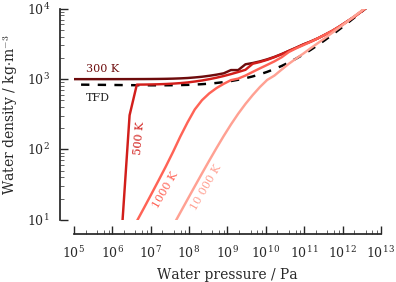

In [9]:
makefig("eos_contours") do
    # make contours for a few different temperatures
    Prange = logspace(log10(minP), log10(maxP))
    Tsamples = (300, 500, 1000, 10000)

    # choose colours
    N = length(Tsamples)
    cmap = colormap("Reds", N+2)[3:end] |> reverse
    cmap = map(c -> (red(c), green(c), blue(c)), cmap)

    # plot the TFD P-ρ relation
    tfd = WaterData.load_functional_eoses()["seager"]["h2o_tfd"]
    ρ = map(tfd, Prange)
    plot(Prange, ρ, color=:black, linestyle="--")

    # plot the contours
    for (i, T) in enumerate(Tsamples)
        ρ = map(P -> eosgrid(P, T), Prange)
        plot(Prange, ρ, color=cmap[i])
    end
    
    # axes
    xscale("log")
    yscale("log")
    xlim(1e5, 1e13)
    ylim(1e1, 1e4)
    kgm3 = L"kg$⋅$m$^{-3}$"
    xlabel("Water pressure / Pa")
    ylabel("Water density / $kgm3")
    despine(touching=false)

    # label the lines
    annotate("TFD", xy=(2e5, 5e2), fontsize=fontsize-2)
    annotate("300 K", xy=(2e5, 1.3e3), fontsize=fontsize-2, color=cmap[1])
    annotate("500 K", xy=(3.5e6, 2e2), fontsize=fontsize-2, color=cmap[2], rotation=85)
    annotate("1000 K", xy=(1e7, 4e1), fontsize=fontsize-2, color=cmap[3], rotation=60)
    annotate("10 000 K", xy=(1e8, 5e1), fontsize=fontsize-2, color=cmap[4], rotation=60)
end

# Mass-radius comparisons

## Seager 2007

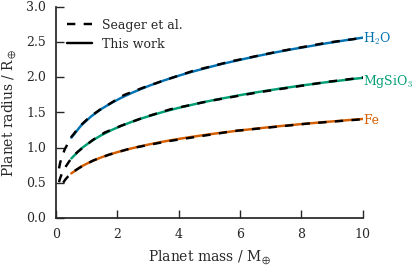

In [10]:
makefig("seager_comparisons") do
    # read in data
    s_h2o = readmr("fromfigures/seager2007/h2o")
    s_mgsio3 = readmr("fromfigures/seager2007/mgsio3")
    s_fe = readmr("fromfigures/seager2007/fe")
    comparisons = [s_h2o, s_mgsio3, s_fe]
    
    my_h2o = readmr("mine/seager2007/h2o")
    my_mgsio3 = readmr("mine/seager2007/mgsio3")
    my_fe = readmr("mine/seager2007/fe")
    mine = [my_h2o, my_mgsio3, my_fe]
    
    # sort tables by mass so they plot correctly
    foreach(sort!, comparisons)
    foreach(sort!, mine)

    # plot everything
    plotmine(x) = plot(x[:mass], x[:radius])
    plotcomp(x) = plot(x[:mass], x[:radius], linestyle="--", color=:black)
    foreach(plotmine, mine)
    foreach(plotcomp, comparisons)
    
    # axes
    xlim(0, 10)
    ylim(0, 3)
    xlabel(L"Planet mass / M$_⊕$")
    ylabel(L"Planet radius / R$_⊕$")
    despine()
    
    # labels
    anns = Dict(:fontsize=>fontsize-1)
    annotate(L"H$_2$O", xy=(10, 2.5), color=palette(1); anns...)
    annotate(L"MgSiO$_3$", xy=(10, 1.9), color=palette(2); anns...)
    annotate("Fe", xy=(10, 1.35), color=palette(3); anns...)
    
    # dummy lines for legend
    plot(0, 0, linestyle="--", color=:black, 
        label="Seager et al.")
    plot(0, 0, color=:black, label="This work")
    
    legend(loc=:best)
end

## Valencia et al 2006/7

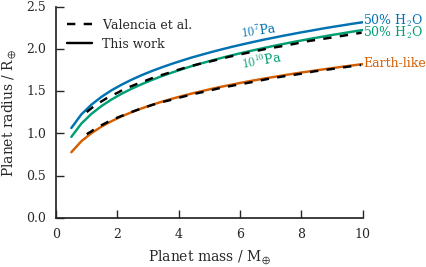

In [11]:
makefig("valencia_comparisons") do
    # read in data
    v_dry = readmr("fromfigures/valencia2007/dry")
    v_wet = readmr("fromfigures/valencia2007/wet")
    comparisons = [v_dry, v_wet]
    my_dry = readmr("mine/valencia2007/dry")
    my_wet_highP = readmr("mine/valencia2007/wet_1e10Pa")
    my_wet_medP = readmr("mine/valencia2007/wet_1e7Pa")
    mine = [my_dry, my_wet_medP, my_wet_highP]
    
    # the data from the paper has radii in km so normalise to R⊕
    v_dry[:radius] /= 6400
    v_wet[:radius] /= 6400
    
    # sort by mass so everything plots correctly
    foreach(sort!, comparisons)
    foreach(sort!, mine)
    
    # plot
    plotmine(x) = plot(x[:mass], x[:radius])
    plotcomp(x) = plot(x[:mass], x[:radius], linestyle="--", color=:black)
    orderpalette([3,1,2]) do
        foreach(plotmine, mine)
        foreach(plotcomp, comparisons)
    end
    
    # axes
    xlim(0, 10)
    ylim(0, 2.5)
    xlabel(L"Planet mass / M$_⊕$")
    ylabel(L"Planet radius / R$_⊕$")
    despine()
    
    # labels
    anns = Dict(:fontsize=>fontsize-1)
    annotate("Earth-like", xy=(10, 1.8), color=palette(3); anns...)
    annotate(L"50% H$_2$O", xy=(10, 2.3), color=palette(1); anns...)
    annotate(L"50% H$_2$O", xy=(10, 2.15), color=palette(2); anns...)
    annotate(L"$10^7$Pa", xy=(6, 2.2), color=palette(1), rotation=8; anns...)
    annotate(L"$10^{10}$Pa", xy=(6, 1.85), color=palette(2), rotation=10; anns...)

    
    # dummy lines for legend
    plot(0, 0, linestyle="--", color=:black, 
    label="Valencia et al.")
    plot(0, 0, color=:black, label="This work")
    
    legend(loc=:best)
end

## Lopez et al 2012

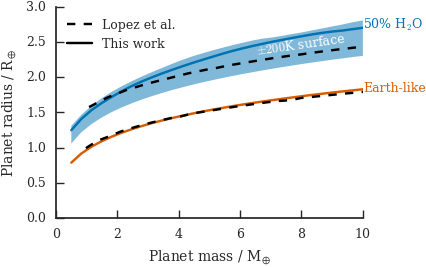

In [12]:
makefig("lopez_comparisons") do
    # read in data
    l_dry = readmr("fromfigures/lopez2012/dry")
    l_wet50 = readmr("fromfigures/lopez2012/wet50")
    l_wet100 = readmr("fromfigures/lopez2012/wet100")
    comparisons = [l_dry, l_wet50]
    my_dry = readmr("mine/lopez2012/dry")
    my_wet50 = readmr("mine/lopez2012/wet50")
    my_wet50_colder = readmr("mine/lopez2012/wet50_colder")
    my_wet50_hotter = readmr("mine/lopez2012/wet50_hotter")
    my_wet100 = readmr("mine/lopez2012/wet100")
    mine = [my_dry, my_wet50]
    
    # sort by mass so everything plots correctly
    foreach(sort!, comparisons)
    foreach(sort!, mine)
    
    # plot
    plotmine(x; kwargs...) = plot(x[:mass], x[:radius]; kwargs...)
    plotcomp(x) = plot(x[:mass], x[:radius], linestyle="--", color=:black)
    orderpalette([3,1]) do
        foreach(plotmine, mine)
        foreach(plotcomp, comparisons)
    end
    fillcolor = (palette()[1]..., 0.5)
    fill_between(my_wet50[:mass], 
        my_wet50_colder[:radius], my_wet50_hotter[:radius],
        facecolor=fillcolor, linewidth=0)
    
    # axes
    xlim(0, 10)
    ylim(0, 3)
    xlabel(L"Planet mass / M$_⊕$")
    ylabel(L"Planet radius / R$_⊕$")
    despine()
    
    # labels
    anns = Dict(:fontsize=>fontsize-1)
    annotate("Earth-like", xy=(10, 1.8), color=palette(3); anns...)
    annotate(L"50% H$_2$O", xy=(10, 2.7), color=palette(1); anns...)
    annotate(L"$\pm200$K surface", xy=(6.5, 2.5), color=:white, 
        rotation=8; anns...)
    
    # dummy lines for legend
    plot(0, 0, linestyle="--", color=:black, 
    label="Lopez et al.")
    plot(0, 0, color=:black, label="This work")
    
    legend(loc=:best)
end

# Mass-radius panels

## Adiabatic treatment vs isothermal treatment

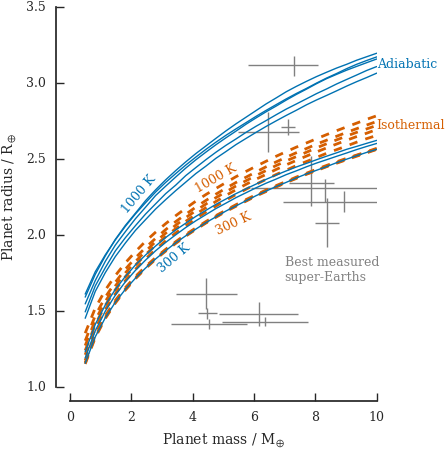

In [13]:
makefig("isothermsadiabats"; tall=true) do
    # Read in data
    adb = readmr("mine/isotherms_vs_adiabats/R_adiabat")
    iso = readmr("mine/isotherms_vs_adiabats/R_isotherm")
    Ts = 300:100:1000
    
    mass(x) = x[:MASS]
    radius(x) = x[:R]
    muncertainty(x) = x[:UMASS]
    runcertainty(x) = x[:UR]
    mprecision(x) = muncertainty(x) ./ mass(x)
    rprecision(x) = runcertainty(x) ./ radius(x)

    df = readtable("figdata/super-Earths.csv")
    df[:MASSPREC] = mprecision(df)
    df[:RPREC] = rprecision(df)
    df[:PREC] = mprecision(df) .* rprecision(df)
    small = df[radius(df) .< 3.5, :]
    sort!(small, cols=:PREC)
    best = head(small, 12)
    
    mass = best[:MASS]
    radius = best[:R]
    xerrs = Array(best[[:MASSLOWER, :MASSUPPER]])'
    yerrs = Array(best[[:RLOWER, :RUPPER]])'
    
    
    # Plot
    plotadiabat(T) = plot(adb[:mass], adb[symbol("x$T")],
        linewidth=1, linestyle="-", color=palette(1))
    plotisotherm(T) = plot(iso[:mass], iso[symbol("x$T")], 
        linewidth=2, linestyle="--", color=palette(3))
    
    errorbar(mass, radius, fmt=",", xerr=xerrs, yerr=yerrs, 
        color=:gray, linewidth=1, capsize=0)

    foreach(plotisotherm, Ts)
    foreach(plotadiabat, Ts)
    
    # axes
    xlim(0, 10)
    ylim(1, 3.5)
    xlabel(L"Planet mass / M$_⊕$")
    ylabel(L"Planet radius / R$_⊕$")
    despine(touching=false)
    
    # annotations
    anns = Dict(:fontsize=>fontsize-1)
    annotate("Adiabatic"; xy=(10, 3.1), color=palette(1), anns...)
    annotate("1000 K"; xy=(1.6, 2.35), color=palette(1), 
        rotation=50, anns...)
    annotate("300 K"; xy=(2.8, 1.9), color=palette(1), 
        rotation=40, anns...)
    annotate("Isothermal"; xy=(10, 2.7), color=palette(3), anns...)
    annotate("1000 K"; xy=(4, 2.42), color=palette(3), 
        rotation=30, anns...)
    annotate("300 K"; xy=(4.7, 2.1), color=palette(3),
        rotation=25, anns...)
    
#     annotate("Kepler-78 b"; xy=(2, 1.06), color=:gray, anns...)
#     annotate("CoRoT-7 b"; xy=(4.6, 1.51), color=:gray, anns...)
#     annotate("GJ 1214 b"; xy=(5.8, 2.8), color=:gray, ha=:right, anns...)
#     annotate("HD 97658 b"; xy=(7.96, 2.24), color=:gray, anns...)
#     annotate("55 Cnc e"; xy=(8.48, 1.98), color=:gray, anns...)
#     annotate("Kepler-10 b"; xy=(4.6,1.326), color=:gray, anns...)
    annotate("Best measured\nsuper-Earths"; xy=(7, 1.7), color=:gray, anns...)
end

## Changing surface pressures

PyPlot.Figure(PyObject <matplotlib.figure.Figure object at 0x7f3559b3c550>)

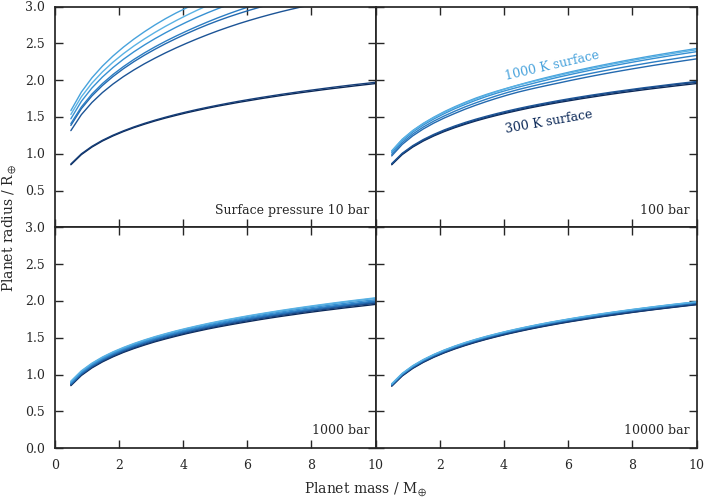

In [23]:
makefig("pressures", big=true) do
    # Plot parameter ranges
    log10Ps = 6:9
    Ts = 300:100:1000
    
    # Load in data
    pr = Dict()
    for log10P in log10Ps
        pr[log10P] = readmr("mine/surfacepressures/1e$log10P")
    end
    
    # Set up subplots
    fig, axes = subplots(2, 2, sharex=true, sharey=true)
    axes = axes' # left-to-right then top-to-bottom
    subplots_adjust(wspace=0, hspace=0)
    
    # Choose plot colours
    cmap = colormap("Blues", length(Ts)*2)
    cmap = collect(drop(cmap, length(Ts))) |> reverse
    cmap = map(c -> (red(c), green(c), blue(c)), cmap)
    
    # Plot
    function plotmr(log10P, T, color)
        mass = pr[log10P][:mass]
        radius = pr[log10P][symbol("x$T")]
        plot(mass, radius, linewidth=1, color=color)
    end
    for (ax, log10P) in zip(axes, log10Ps)
        sca(ax)
        for (T, c) in zip(Ts, cmap)
            plotmr(log10P, T, c)
        end
        ylim(0, 3)
    end
    
    # Labels
    fullxlabel(fig, L"Planet mass / M$_⊕$")
    fullylabel(fig, L"Planet radius / R$_⊕$")
    for nplot = (1, 4)
        removezeroticks!(axes[nplot])
    end
    
    # annotations
    # temperature scale
    anns = Dict(:fontsize=>fontsize-1)
    sca(axes[2])
    annotate("300 K surface", xy=(4, 1.5), color=cmap[1], rotation=10; anns...)
    annotate("1000 K surface", xy=(4, 2.3), color=cmap[end-1], rotation=13; anns...)
    
    # surface pressures
    for (plotnum, log10P) in enumerate(log10Ps)
        log10bar = log10P - 5
        bar = 10 .^ log10bar
        sca(axes[plotnum])
        text = (plotnum == 1 ? "Surface pressure $bar bar" : "$bar bar")
        annotate(text, xy=(9.8, 0.2), horizontalalignment=:right; anns...)
    end 
end

## Changing compositions

PyPlot.Figure(PyObject <matplotlib.figure.Figure object at 0x7f354f4bf3c8>)

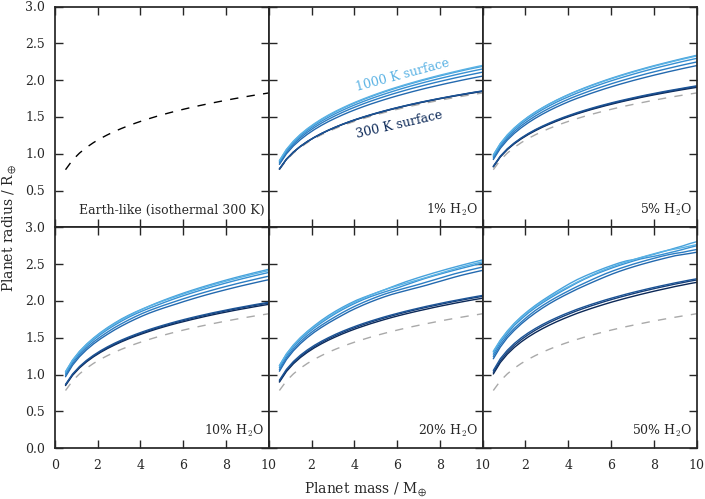

In [24]:
makefig("compositions", big=true) do
    # Plot parameter ranges
    waterpcs = [0, 1, 5, 10, 20, 50]
    Ts = 300:100:1000
    
    # Load in data
    cmp = Dict()
    for waterpc in waterpcs
        cmp[waterpc] = readmr("mine/h2ofractions/$(waterpc)pc")
    end
    
    # Set up subplots
    fig, axes = subplots(2, 3, sharex=true, sharey=true)
    axes = axes' # left-to-right then top-to-bottom
    subplots_adjust(wspace=0, hspace=0)
    
    # Choose plot colours
    cmap = colormap("Blues", length(Ts)*2)
    cmap = collect(drop(cmap, length(Ts))) |> reverse
    cmap = map(c -> (red(c), green(c), blue(c)), cmap)
    
    # Plot Earth-like core baseline
    for (i, ax) in enumerate(axes)
        earthcol = :black
        if i != 1
            earthcol = :darkgray
        end
        sca(ax)
        mass = cmp[0][:mass]
        radius = cmp[0][:x300]
        plot(mass, radius, color=earthcol, linewidth=1, linestyle="--")
    end
    
    # Plot watery models
    dropfirst(x) = drop(x, 1)
    function plotmr(waterpc, T, color)
        mass = cmp[waterpc][:mass]
        radius = cmp[waterpc][symbol("x$T")]
        plot(mass, radius, linewidth=1, color=color)
    end
    for (ax, waterpc) in (zip(axes, waterpcs) |> dropfirst)
        sca(ax)
        for (T, c) in zip(Ts, cmap)
            plotmr(waterpc, T, c)
        end
        ylim(0, 3)
    end
    
    # Labels
    fullxlabel(fig, L"Planet mass / M$_⊕$")
    fullylabel(fig, L"Planet radius / R$_⊕$")
    for nplot = (1, 5, 6)
        removezeroticks!(axes[nplot])
    end
    
    # annotations
    # temperature scale
    anns = Dict(:fontsize=>fontsize-1)
    sca(axes[2])
    annotate("300 K surface", xy=(4, 1.5), color=cmap[1], rotation=13; anns...)
    annotate("1000 K surface", xy=(4, 2.2), color=cmap[end], rotation=15; anns...)
    
    # water fractions
    sca(axes[1])
    annotate("Earth-like (isothermal 300 K)", xy=(9.8, 0.2), horizontalalignment=:right; anns...)
    for (plotnum, waterpc) in (enumerate(waterpcs) |> dropfirst)
        sca(axes[plotnum])
        text = "$(waterpc)% H\$_2\$O"
        annotate(text, xy=(9.8, 0.2), horizontalalignment=:right; anns...)
    end 
end